#Reference
Code done using the official github repository and the documnetation
https://github.com/SeldonIO/alibi-detect
https://docs.seldon.io/projects/alibi-detect/en/latest

In [ ]:
!pip install alibi-detect


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 113.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.3 MB/s eta 0:00:00


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image


2.11.0


In [ ]:
image_directory = '/content/drive/MyDrive/Project/Outlierdetect/non-pd-outlier/'
SIZE = 64
dataset = []


In [ ]:
good_images = os.listdir(image_directory + 'Good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

dataset = np.array(dataset)

train = dataset[0:200]
test = dataset[200:279]

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.

In [ ]:
#Let us also load bad images to verify our trained model.
bad_images = os.listdir(image_directory + 'Bad')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'Bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.


In [ ]:
encoding_dim = 1024  #Dimension of the bottleneck encoder vector.
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder.

#Define encoder
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())
#print(encoder_net.input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())
#print(decoder_net.input_shape)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             33587200  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 64)       262208    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 3)        3075      
 ranspose)                                                       
                                                      

In [ ]:
#Define and train the outlier detector.

latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=20,
       batch_size=4,
       verbose=True)

#Check the threshold value. Should be the same as defined before.
print("Current threshold value is: ", od.threshold)

od.infer_threshold(test, outlier_type='instance', threshold_perc=99.0)
print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.015


50/50 [=] - 3s 62ms/step - loss_ma: 1197.4080
Current threshold value is:  0.015
Current threshold value is:  0.017292816117405886


In [ ]:
image_directory = '/content/drive/MyDrive/Project/dataset-png/non-pd/'
SIZE = 64
real_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
img_name = []
count=0

real_images = os.listdir(image_directory)
for i, image_name in enumerate(real_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        img_name.append(np.array(image_name))
        real_dataset.append(np.array(image))
        count=count+1

real_dataset = np.array(real_dataset)
real_dataset = real_dataset.astype('float32') / 255.
print(len(real_dataset))
print(count)


986
986


In [ ]:
i=0
with open('gooimages.txt', 'w') as f:
  while i<5:
    lines = i
    f.writelines(str(lines)+"\n")
    i=i+1


In [ ]:
from numpy.random.mtrand import f
#for detecting outliers in a dataset

with open('badimages.txt', 'w') as f:
  #print(real_dataset)
  img_num = 0
  while img_num < len(real_dataset):
    print(img_num)
    im=real_dataset[img_num]
    test_bad_image = real_dataset[img_num].reshape(1, 64, 64, 3)
    #plt.imshow(test_bad_image[0])
    test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

    bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
    print("The instance score is:", bad_image_instance_score)

    bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
    #plt.imshow(bad_image_feature_score[:,:,0])
    print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])
    x= test_bad_image_predict['data']['is_outlier'][0]


    if x==1:
      #plt.imshow(real_dataset[img_num])
      im=real_dataset[img_num]
      #im2 = np.random.random_sample(im.shape) * 255
      #im2 = im2.astype(np.uint8)
      new_file = str(img_name[img_num])
      f.writelines(new_file+"\n")


    img_num=img_num+1


0
The instance score is: 0.012803231
Is this image an outlier (0 for NO and 1 for YES)? 0
1
The instance score is: 0.008815713
Is this image an outlier (0 for NO and 1 for YES)? 0
2
The instance score is: 0.013817378
Is this image an outlier (0 for NO and 1 for YES)? 0
3
The instance score is: 0.009664222
Is this image an outlier (0 for NO and 1 for YES)? 0
4
The instance score is: 0.014461498
Is this image an outlier (0 for NO and 1 for YES)? 0
5
The instance score is: 0.012014836
Is this image an outlier (0 for NO and 1 for YES)? 0
6
The instance score is: 0.012175143
Is this image an outlier (0 for NO and 1 for YES)? 0
7
The instance score is: 0.00958001
Is this image an outlier (0 for NO and 1 for YES)? 0
8
The instance score is: 0.009414612
Is this image an outlier (0 for NO and 1 for YES)? 0
9
The instance score is: 0.009440341
Is this image an outlier (0 for NO and 1 for YES)? 0
10
The instance score is: 0.009947781
Is this image an outlier (0 for NO and 1 for YES)? 0
11
The ins

0
The instance score is: 0.00048326002
Is this image an outlier (0 for NO and 1 for YES)? 0
1
The instance score is: 0.00066888565
Is this image an outlier (0 for NO and 1 for YES)? 0
2
The instance score is: 0.00039584553
Is this image an outlier (0 for NO and 1 for YES)? 0
3
The instance score is: 0.00062381336
Is this image an outlier (0 for NO and 1 for YES)? 0
4
The instance score is: 0.0004165182
Is this image an outlier (0 for NO and 1 for YES)? 0
5
The instance score is: 0.0001770428
Is this image an outlier (0 for NO and 1 for YES)? 0
6
The instance score is: 0.00020310609
Is this image an outlier (0 for NO and 1 for YES)? 0
7
The instance score is: 0.00018489565
Is this image an outlier (0 for NO and 1 for YES)? 0
8
The instance score is: 0.00022701976
Is this image an outlier (0 for NO and 1 for YES)? 0
9
The instance score is: 0.00025140212
Is this image an outlier (0 for NO and 1 for YES)? 0
10
The instance score is: 0.0002622172
Is this image an outlier (0 for NO and 1 fo

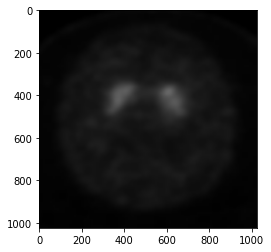

In [ ]:
from numpy.random.mtrand import f
#for detecting outliers in a dataset


#print(real_dataset)
img_num = 0
while img_num < len(real_dataset):
  print(img_num)
  im=real_dataset[img_num]
  test_bad_image = real_dataset[img_num].reshape(1, 64, 64, 3)
  #plt.imshow(test_bad_image[0])
  test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

  bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
  print("The instance score is:", bad_image_instance_score)

  bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
  #plt.imshow(bad_image_feature_score[:,:,0])
  print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])
  x= test_bad_image_predict['data']['is_outlier'][0]


  if x==1:
    #plt.imshow(real_dataset[img_num])
    im=real_dataset[img_num]
    #im2 = np.random.random_sample(im.shape) * 255
    #im2 = im2.astype(np.uint8)
    new_file = str(img_name[img_num])
    print(new_file)
    im = Image.fromarray((im * 255).astype(np.uint8))
    image=im.resize((1024,1024))
    bad_path='/content/drive/MyDrive/Project/Outlierdetect/real_dataset/bad/'
    completeName = os.path.join(bad_path,new_file)
    im.save(completeName)
  else:
    #plt.imshow(real_dataset[img_num])
    im=real_dataset[img_num]
    #im2 = np.random.random_sample(im.shape) * 255
    #im2 = im.astype(np.uint8)
    new_file = str(img_name[img_num])
    #print(new_file)
    im = Image.fromarray((im * 255).astype(np.uint8))
    image=im.resize((1024,1024))
    good_path= '/content/drive/MyDrive/Project/Outlierdetect/real_dataset/good/'
    completeName = os.path.join(good_path,new_file)
    im.save(completeName)
    plt.imshow(image)

  img_num=img_num+1





The instance score is: 0.0026941476
Is this image an outlier (0 for NO and 1 for YES)? 1


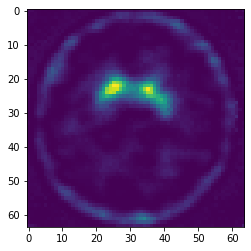

In [ ]:
# save the trained outlier detector
#As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7
#from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
#from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work.
#save_detector(od, "saved_outlier_models/carpet_od_20epochs.h5")
#od = load_detector(filepath)

#Test our model on a bad image
img_num = 2
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
#plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not.
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])


The instance score is: 779.80914
Is this image an outlier (0 for NO and 1 for YES)? 1


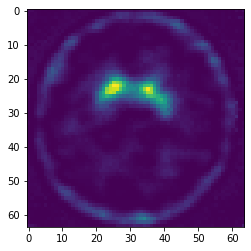

In [ ]:
img_num = 19
test_good_image = dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_good_image[0])

test_good_image_recon = od.vae(test_good_image)
test_good_image_recon = test_good_image_recon.numpy()
plt.imshow(test_good_image_recon[0])

test_good_image_predict = od.predict(test_good_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not.
#Let u look at the values under the 'data' key in our output dictionary
good_image_instance_score = test_good_image_predict['data']['instance_score'][0]
print("The instance score is:", good_image_instance_score)

good_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(good_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_good_image_predict['data']['is_outlier'][0])


Current threshld value is:  0.0002
['instance_score', 'feature_score', 'is_outlier']


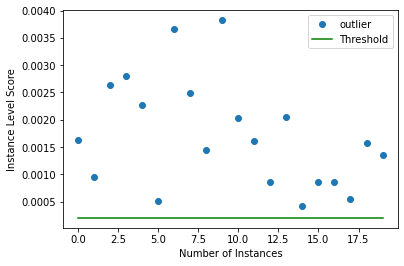

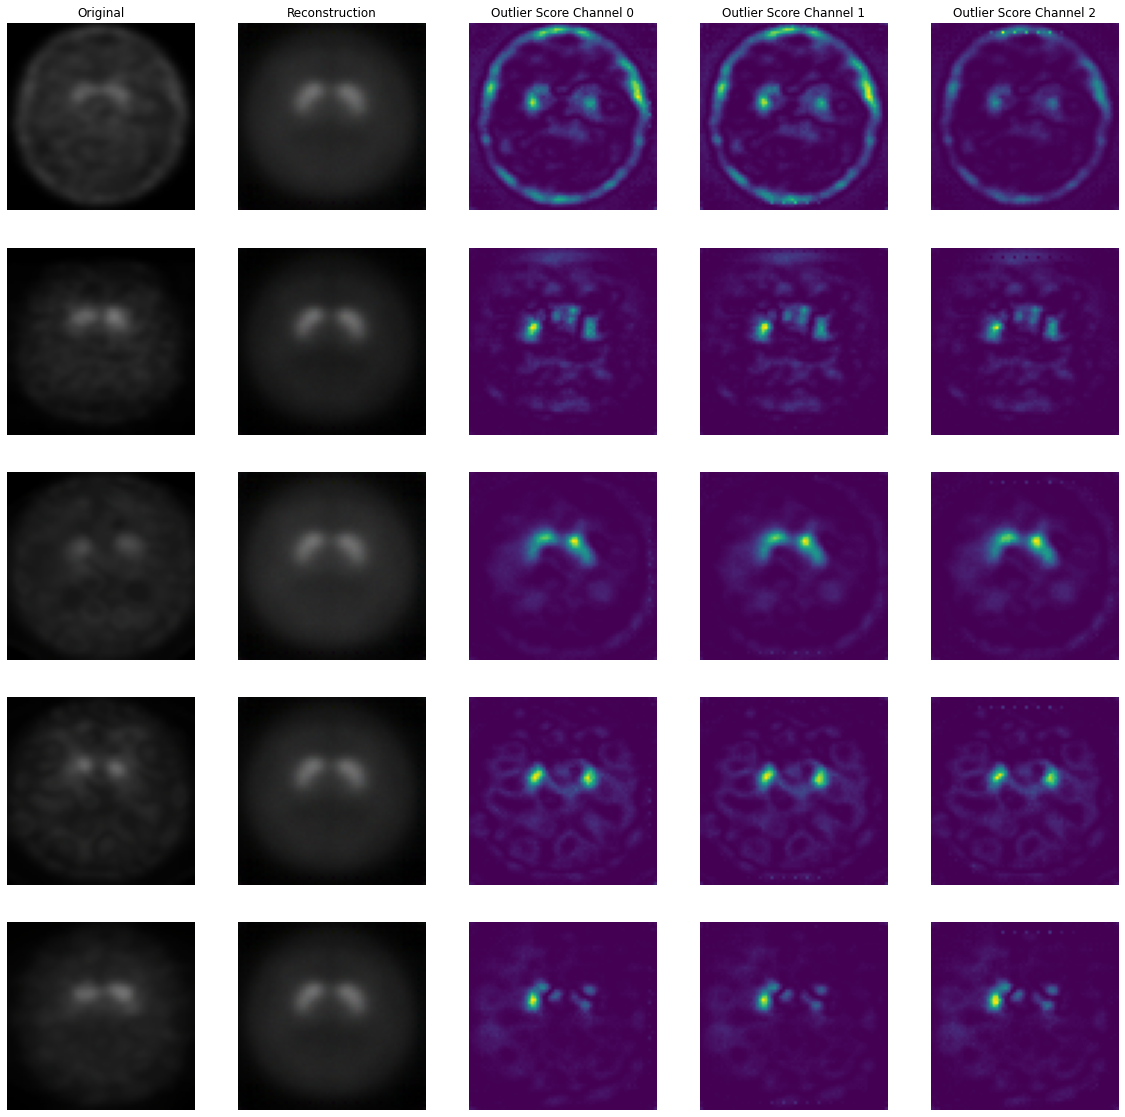

In [ ]:
#You can also manually define the threshold based on your specific use case.
od.threshold = 0.0002
print("Current threshld value is: ", od.threshold)

#Let us check it for multiple images
X = bad_dataset[:20]

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot.
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

#Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[0, 5, 10, 15, 17],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions

#######################################